# Initialization

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from result_saver import SaverProvider

provider = SaverProvider()

# Initialize simulator

In [3]:
from soft_info import RepCodeIQSimulator

DEVICE = 'ibm_sherbrooke'
DISTANCE = 11
ROUNDS = 11
OTHER_DATE = '2023-10-27'
_RESETS = False
LOGICAL = 0 # NOT NEEDED FOR EXTREME IQ BCS HARDCODED 0

_is_hex = True
if DEVICE == 'ibmq_mumbai':
    _is_hex = False

# Initialize simulator
simulator = RepCodeIQSimulator(provider, DISTANCE, ROUNDS, DEVICE, _is_hex=_is_hex, _resets = _RESETS, other_date=OTHER_DATE)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.
Searching for ibm_sherbrooke and 23.10.27_07h46_300pts_2std


# Get IQ data

In [4]:
SHOTS = int(1e4)
NOISE_LIST = [3e-2, 0.8e-2, 1e-2, 3e-2] # [two-qubit-fidelity, reset error, measurement error, idle error]
# NOISE_LIST = None
P_AMBIG = 0.1

IQ_data= simulator.generate_IQ(SHOTS, noise_list=NOISE_LIST)

# Simulator

# Decode IQ data

In [5]:
import pymatching
import stim

model = simulator.stim_circ.detector_error_model(decompose_errors=False)
matching = pymatching.Matching.from_detector_error_model(model)

In [6]:
import numpy as np
import cpp_soft_info
from Scratch import load_calibration_memory

# bandwidths = np.linspace(0.05, 0.9, 20)
# bandwidths =[0.6]
bandwidths = np.linspace(0.4, 0.7, 20)
all_memories = load_calibration_memory(provider, tobecalib_backend=DEVICE, other_date=OTHER_DATE)
kde_dict = cpp_soft_info.get_KDEs(all_memories, bandwidths, relError=1, absError=-1, num_points=4)

Found jobs for backend ibm_sherbrooke with closest execution date 2023-10-27 08:32:22.841567+00:00.


# Convertor decoding

In [7]:
from soft_info import inv_qubit_mapping

qubit_mapping = simulator.qubit_mapping
inv_qubit_mapping = inv_qubit_mapping(qubit_mapping)
print(inv_qubit_mapping)

{114: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 116: [1, 11, 21, 31, 41, 51, 61, 71, 81, 91, 101], 118: [2, 12, 22, 32, 42, 52, 62, 72, 82, 92, 102], 120: [3, 13, 23, 33, 43, 53, 63, 73, 83, 93, 103], 122: [4, 14, 24, 34, 44, 54, 64, 74, 84, 94, 104], 104: [5, 15, 25, 35, 45, 55, 65, 75, 85, 95, 105], 102: [6, 16, 26, 36, 46, 56, 66, 76, 86, 96, 106], 100: [7, 17, 27, 37, 47, 57, 67, 77, 87, 97, 107], 98: [8, 18, 28, 38, 48, 58, 68, 78, 88, 98, 108], 96: [9, 19, 29, 39, 49, 59, 69, 79, 89, 99, 109], 113: [110], 115: [111], 117: [112], 119: [113], 121: [114], 111: [115], 103: [116], 101: [117], 99: [118], 97: [119], 95: [120]}


In [8]:
pSoft, countMat = cpp_soft_info.iqConvertor(IQ_data, inv_qubit_mapping, kde_dict, 1, -1)

In [9]:
print(f"shape of pSoft: {pSoft.shape}")

# check if there is a nan in the pSoft
if np.isnan(pSoft).any():
    print("There is a nan in the pSoft")

# Print the indices of the nan
print(np.argwhere(np.isnan(pSoft)))


shape of pSoft: (10000, 121)
[]


In [10]:
print(countMat)
if np.isnan(countMat).any():
    print("There is a nan in the countMat")
else:
    print("There is no nan in the countMat")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [1 1 1 ... 1 1 0]
 ...
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 0 1]
 [0 0 0 ... 0 0 1]]
There is no nan in the countMat


In [11]:
print(f"IQ_data shape: {IQ_data.shape}")
print(f"pSoft shape: {pSoft.shape}")
print(f"countMat shape: {countMat.shape}")

IQ_data shape: (10000, 121)
pSoft shape: (10000, 121)
countMat shape: (10000, 121)


In [12]:
result = cpp_soft_info.decodeConvertorSoft(model, countMat, pSoft, ROUNDS, int(LOGICAL), _RESETS, False)
print(result.num_errors)

65


# Quantize the matrix

In [17]:
pSoft_quantized = cpp_soft_info.quantizeMatrixVectorized(pSoft, nBits=20)
# print(pSoft_quantized)

In [14]:
result = cpp_soft_info.decodeConvertorSoft(model, countMat, pSoft_quantized, ROUNDS, int(LOGICAL), _RESETS, False)
print(result.num_errors)

64


In [15]:
from tqdm import tqdm

errs = []
for i in tqdm(range(1, 15, 1)):
    pSoft_quantized = cpp_soft_info.quantizeMatrixVectorized(pSoft, nBits=i)
    result = cpp_soft_info.decodeConvertorSoft(model, countMat, pSoft_quantized, ROUNDS, int(LOGICAL), _RESETS, False)
    errs.append(result.num_errors)

100%|██████████| 14/14 [00:04<00:00,  3.31it/s]


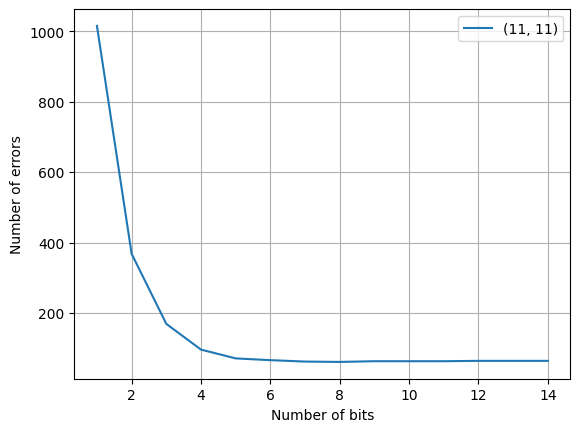

In [16]:
import matplotlib.pyplot as plt

plt.plot(range(1, 15, 1), errs, label=f"({DISTANCE}, {ROUNDS})")
plt.xlabel("Number of bits")
plt.ylabel("Number of errors")
plt.legend()
plt.grid()


# Using cpp kde

In [14]:
_DETAILED = False

matching = pymatching.Matching.from_detector_error_model(model)
result = cpp_soft_info.decode_IQ_fast(model, IQ_data,
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                           simulator.processed_scaler_dict, _detailed=_DETAILED, nb_intervals=-1)

print("num_errors IQ:", result.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)

num_errors IQ: 34 out of 10000 shots for _RESETS = False


In [15]:
_DETAILED = False

relError = 1
absError = -1

# relError = 1
# absError = 10

result_kde = cpp_soft_info.decode_IQ_kde(model, IQ_data, ROUNDS, int(LOGICAL), _RESETS, 
                                         simulator.qubit_mapping, kde_dict, _DETAILED, relError=relError, absError=absError,
                                         nb_intervals=-1)

print("num_errors KDE:", result_kde.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)

num_errors KDE: 26 out of 10000 shots for _RESETS = False


In [ ]:
p_meas = -1
# p_meas = 7e-2 

result_informed = cpp_soft_info.decode_IQ_shots_flat_informed(model, IQ_data[:],
                                           ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict,
                                           p_data = -1, p_mixed = -1, p_meas = p_meas, common_measure=-1, _detailed=_DETAILED, _ntnn_edges = True)

print("num_errors informed:", result_informed.num_errors, "out of", len(IQ_data), "shots for _RESETS =", _RESETS)
         
# takes 1s

num_errors informed: 0 out of 100 shots for _RESETS = False
num_errors informed EXTREME: 8 out of 100 shots for _RESETS = False


# Plot the results

In [ ]:
print("\nIQ:", result.indices, "\nkde:", sorted(result_kde.indices), "\nInformed", result_informed.indices)


IQ: [] 
kde: [] 
Flat: [] 
Informed []

IQ EXTREME: [] 
kde EXTREME: [] 
Flat EXTREME: [] 
Informed EXTREME []


----- First True decoding -----


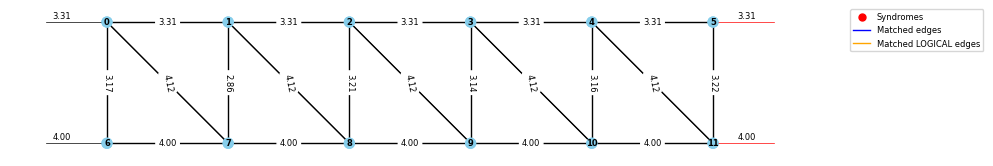

-----Second True decoding-----


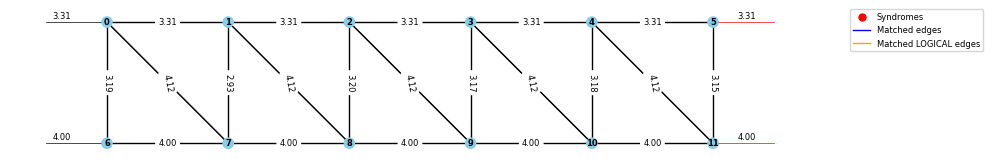

-----Third True decoding-----


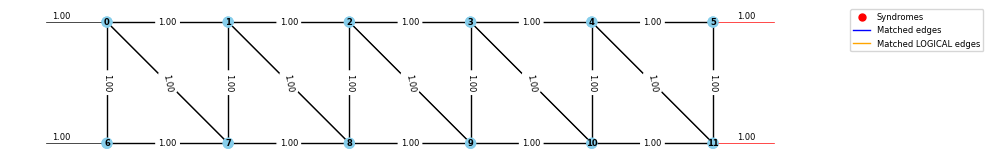

In [ ]:
from soft_info import draw_matching_graph


index = 10

fig_size = (4, 13)
fig_size = (8, 8)
scale_factor = 0.5

to_be_result = result_kde
details = to_be_result.error_details[index]
print(f"----- First {bool(not (index in to_be_result.indices))} decoding -----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result
details = to_be_result.error_details[index]
print(f"-----Second {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)

to_be_result = result_flat
details = to_be_result.error_details[index]
print(f"-----Third {bool(not (index in to_be_result.indices))} decoding-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)


In [ ]:
informed_not_in_iq = sorted(set(result_informed.indices) - set(result.indices))
print("indices that are in informed but not in IQ with len:", len(informed_not_in_iq))
print(informed_not_in_iq)
iq_not_in_informed = sorted(set(result.indices) - set(result_informed.indices))
print("indices that are in IQ but not in informed with len:", len(iq_not_in_informed))
print(iq_not_in_informed)

print()

iq_not_in_flat = sorted(set(result.indices) - set(result_flat.indices))
print("indices that are in IQ but not in flat with len:", len(iq_not_in_flat))
print(iq_not_in_flat)
flat_not_in_iq = sorted(set(result_flat.indices) - set(result.indices))
print("indices that are in flat but not in IQ with len:", len(flat_not_in_iq))
print(flat_not_in_iq)

print()

iq_not_in_kde = sorted(set(result.indices) - set(result_kde.indices))
print("indices that are in IQ but not in kde with len:", len(iq_not_in_kde))
print(iq_not_in_kde)
kde_not_in_iq = sorted(set(result_kde.indices) - set(result.indices))
print("indices that are in kde but not in IQ with len:", len(kde_not_in_iq))
print(kde_not_in_iq)

indices that are in informed but not in IQ with len: 0
[]
indices that are in IQ but not in informed with len: 0
[]

indices that are in IQ but not in flat with len: 0
[]
indices that are in flat but not in IQ with len: 0
[]

indices that are in IQ but not in kde with len: 0
[]
indices that are in kde but not in IQ with len: 0
[]


# Analyse specific shots

{'0010000 001000': 1}


100%|██████████| 25/25 [00:00<00:00, 519097.03it/s]

mean time edge weight: 3.2142805258433023

[(1, 7), (0, -1)]
-----IQ-----


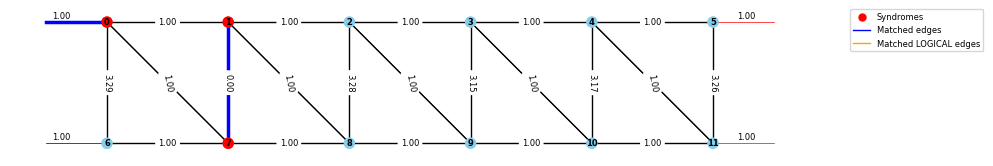

In [ ]:
from tqdm import tqdm

index = 83
IQ_data_new = IQ_data[index:index+1]

esult = cpp_soft_info.decode_IQ_shots(matching._matching_graph, IQ_data_extreme,
                                             ROUNDS, int(LOGICAL), _RESETS, simulator.qubit_mapping, simulator.grid_dict,
                                             simulator.processed_scaler_dict, p_data=-1, p_mixed=-1,
                                             common_measure=-1, _adv_probs=not _RESETS, _bimodal=_RESETS, merge_strategy = "replace", _detailed=_DETAILED,
                                              p_offset = 1, p_multiplicator = 1, _ntnn_edges = True)

print(cpp_soft_info.get_counts(IQ_data_new, simulator.qubit_mapping, simulator.grid_dict, simulator.processed_scaler_dict, ROUNDS))



to_be_result = esult
details = to_be_result.error_details[0]


mean_edge_weight = 0
num_time_edges = 0
for edge in tqdm(matching.edges()):
    src_node, tgt_node, data = edge
    if src_node == None or tgt_node == None:
        continue
    if src_node == tgt_node - (DISTANCE-1):
        mean_edge_weight += data["weight"]
        num_time_edges += 1

print("mean time edge weight:", mean_edge_weight / num_time_edges)

print()
print(details.matched_edges)

print("-----IQ-----")
draw_matching_graph(matching=None, d=DISTANCE, T=ROUNDS, syndromes=details.detection_syndromes,
                        matched_edges=details.matched_edges, figsize=fig_size, scale_factor=scale_factor, edge_list=details.edges)